## Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
TF_ENABLE_ONEDNN_OPTS=0

2022-06-13 19:31:56.984879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 19:31:57.090526: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2022-06-13 19:31:57.649226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-06-13 19:31:57.649264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-06-13 19:31:57.649268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


2022-06-13 19:31:58.371842: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-13 19:31:58.371868: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Nitro-AN515-57
2022-06-13 19:31:58.371872: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Nitro-AN515-57
2022-06-13 19:31:58.371941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-06-13 19:31:58.371963: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-06-13 19:31:58.371967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7


In [2]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir=logs

## Data

In [4]:
file_path = "data_with_features_ver01.csv"
df = pd.read_csv(file_path)
df

,Unnamed: 0,Time_UTC_Start,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,smoothed_minus_DM72,mad72,ATR72,CCI72,plus_DI72,minus_DI72,DX72,ADX72,BOP72,MFI72
0,0,2018-07-24 09:00:00,7991.55,7995.89,7991.52,7994.86,31.547768,2.521824e+05,114.0,17.411796,...,728.673056,161.526701,8.191528,174.835387,16870.670917,8895.447532,30.952366,11.256566,0.141162,55.823217
1,1,2018-07-24 10:00:00,8022.05,8032.85,8022.05,8032.85,11.358339,9.117570e+04,136.0,7.730805,...,689.193056,165.613529,8.218889,180.754117,17529.241584,8385.477220,35.284058,11.590281,0.147690,56.511624
2,2,2018-07-24 11:00:00,8140.18,8145.00,8135.00,8135.00,61.441457,5.001102e+05,296.0,29.340389,...,667.261944,170.471458,8.304167,213.721125,19586.447566,8035.266767,41.819203,12.010127,0.133587,56.879834
3,3,2018-07-24 12:00:00,8257.98,8266.61,8255.02,8263.01,36.020530,2.976317e+05,317.0,16.279052,...,667.261944,176.651978,8.305417,247.779179,20948.826903,8034.057426,44.559987,12.462209,0.138612,57.654664
4,4,2018-07-24 13:00:00,8218.71,8228.68,8216.45,8220.00,59.458543,4.887918e+05,284.0,31.777879,...,743.866250,181.885078,8.400694,221.563167,19001.025048,8854.818550,36.423979,12.795011,0.126266,56.079662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33186,33186,2022-05-07 03:00:00,35953.63,35953.64,35943.60,35951.24,6.376430,2.292318e+05,339.0,3.818980,...,7035.463472,1482.198889,45.395556,-79.503234,9943.275773,15498.132771,21.833921,13.697214,0.042153,61.134462
33187,33187,2022-05-07 04:00:00,35812.22,35826.14,35812.21,35826.14,6.066650,2.173069e+05,348.0,5.129450,...,7222.968611,1503.375019,45.295139,-82.701137,9828.032810,15946.454274,23.738286,13.836674,0.044086,60.964637
33188,33188,2022-05-07 05:00:00,35746.62,35768.06,35722.24,35768.05,34.156320,1.220607e+06,993.0,19.901990,...,7251.375139,1524.164087,45.760833,-83.214330,9728.015831,15846.248004,23.923395,13.976767,0.055374,61.167920
33189,33189,2022-05-07 06:00:00,35898.96,35903.80,35890.03,35900.00,16.707700,5.997658e+05,580.0,10.902570,...,7161.405139,1539.731304,45.436111,-74.759128,10145.099652,15761.483463,21.679369,14.083748,0.045734,61.377534


#### Test naive method:

In [5]:
a = df[(df["volume_SMA4"] >= df["volume_SMA8"])].index
b = df[(df["volume_SMA4"] < df["volume_SMA8"])].index+1
a_b = set(a).intersection(set(b))
lst = sorted(list(a_b))
print((df["close"].to_numpy()[np.array(lst)+1] - df["close"].to_numpy()[lst] >= 0).sum()/len(lst))
print(len(lst))

0.5124072652852392
3909


### Difference percentage

In [6]:
diff_percentage = False

In [7]:
if diff_percentage == True:
    for c in ["close", "high", "open", "low"]:
        df[c] = (df[c] - df[c].shift(1))/df[c].shift(1)
    for c in ["raw_money_flow", "volume", "typical_price", "number_of_trades", "quote_asset_volume", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]:
        df[c] = (df[c] - df[c].shift(1))/df[c].shift(1)/100
        
    # Test
    lst = [4,8,12,16,20,24,48,72]
    for i in range(len(lst)-1):
        for j in range(i+1, len(lst)):
            df["diff_price_SMA%d-%d"%(lst[i],lst[j])] = (df["price_SMA%d"%lst[i]] - df["price_SMA%d"%lst[j]])/df["price_SMA%d"%lst[j]]
            df["diff_volume_SMA%d-%d"%(lst[i],lst[j])] = (df["volume_SMA%d"%lst[i]] - df["volume_SMA%d"%lst[j]])/df["volume_SMA%d"%lst[j]]/100
            df["diff_price_EMA%d-%d"%(lst[i],lst[j])] = (df["price_EMA%d"%lst[i]] - df["price_EMA%d"%lst[j]])/df["price_EMA%d"%lst[j]]
            df["diff_volume_EMA%d-%d"%(lst[i],lst[j])] = (df["volume_EMA%d"%lst[i]] - df["volume_EMA%d"%lst[j]])/df["volume_EMA%d"%lst[j]]/100
            df["diff_price_WMA%d-%d"%(lst[i],lst[j])] = (df["price_WMA%d"%lst[i]] - df["price_WMA%d"%lst[j]])/df["price_WMA%d"%lst[j]]
            df["diff_volume_WMA%d-%d"%(lst[i],lst[j])] = (df["volume_WMA%d"%lst[i]] - df["volume_WMA%d"%lst[j]])/df["volume_WMA%d"%lst[j]]/100

    for i in lst:
        df["RS%d"%(i)]/=100
        df["RSI%d"%(i)]/=100
        df["std%d"%i]/=2000

    df.drop(columns=["Unnamed: 0", "TR", "plus_DM", "minus_DM", "price_diff", "label", "PPO12-26"],inplace=True)
    for i in lst:
        df.drop(columns=["ADX%d"%(i), "BOP%d"%i, "price_SMA%d"%i, "price_EMA%d"%i, "price_WMA%d"%i, "minus_DI%d"%(i), "MFI%d"%i, "plus_DI%d"%i, "ATR%d"%(i), "CCI%d"%i, "DX%d"%i, "mad%d"%(i), "smoothed_minus_DM%d"%i, "smoothed_plus_DM%d"%i, "volume_SMA%d"%i, "volume_EMA%d"%i, "volume_WMA%d"%i], inplace=True)

### Standard Scale

In [8]:
if diff_percentage == False:

    for c in ["close", "high", "open", "low", "raw_money_flow", "volume", "typical_price", "number_of_trades", "quote_asset_volume", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume"]:
        df[c] = df[c] - df[c].shift(1)

    # Test
    lst = [4,8,12,16,20,24,48,72]
    for i in range(len(lst)-1):
        for j in range(i+1, len(lst)):
            df["diff_price_SMA%d-%d"%(lst[i],lst[j])] = (df["price_SMA%d"%lst[i]] - df["price_SMA%d"%lst[j]])
            df["diff_volume_SMA%d-%d"%(lst[i],lst[j])] = (df["volume_SMA%d"%lst[i]] - df["volume_SMA%d"%lst[j]])
            df["diff_price_EMA%d-%d"%(lst[i],lst[j])] = (df["price_EMA%d"%lst[i]] - df["price_EMA%d"%lst[j]])
            df["diff_volume_EMA%d-%d"%(lst[i],lst[j])] = (df["volume_EMA%d"%lst[i]] - df["volume_EMA%d"%lst[j]])
            df["diff_price_WMA%d-%d"%(lst[i],lst[j])] = (df["price_WMA%d"%lst[i]] - df["price_WMA%d"%lst[j]])
            df["diff_volume_WMA%d-%d"%(lst[i],lst[j])] = (df["volume_WMA%d"%lst[i]] - df["volume_WMA%d"%lst[j]])

    df.drop(columns=["Unnamed: 0", "TR", "plus_DM", "minus_DM", "price_diff", "label", "PPO12-26"],inplace=True)
    for i in lst:
        df.drop(columns=["ADX%d"%(i), "BOP%d"%i, "price_SMA%d"%i, "price_EMA%d"%i, "price_WMA%d"%i, "minus_DI%d"%(i), "MFI%d"%i, "plus_DI%d"%i, "ATR%d"%(i), "CCI%d"%i, "DX%d"%i, "mad%d"%(i), "smoothed_minus_DM%d"%i, "smoothed_plus_DM%d"%i, "volume_SMA%d"%i, "volume_EMA%d"%i, "volume_WMA%d"%i], inplace=True)

/tmp/ipykernel_15431/1884725940.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_price_EMA%d-%d"%(lst[i],lst[j])] = (df["price_EMA%d"%lst[i]] - df["price_EMA%d"%lst[j]])
/tmp/ipykernel_15431/1884725940.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_volume_EMA%d-%d"%(lst[i],lst[j])] = (df["volume_EMA%d"%lst[i]] - df["volume_EMA%d"%lst[j]])
/tmp/ipykernel_15431/1884725940.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

/tmp/ipykernel_15431/1884725940.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_volume_WMA%d-%d"%(lst[i],lst[j])] = (df["volume_WMA%d"%lst[i]] - df["volume_WMA%d"%lst[j]])
/tmp/ipykernel_15431/1884725940.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_price_SMA%d-%d"%(lst[i],lst[j])] = (df["price_SMA%d"%lst[i]] - df["price_SMA%d"%lst[j]])
/tmp/ipykernel_15431/1884725940.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

/tmp/ipykernel_15431/1884725940.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_price_EMA%d-%d"%(lst[i],lst[j])] = (df["price_EMA%d"%lst[i]] - df["price_EMA%d"%lst[j]])
/tmp/ipykernel_15431/1884725940.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["diff_volume_EMA%d-%d"%(lst[i],lst[j])] = (df["volume_EMA%d"%lst[i]] - df["volume_EMA%d"%lst[j]])
/tmp/ipykernel_15431/1884725940.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

## Additional preprocessing

In [9]:
df["day"] = pd.to_datetime(df["Time_UTC_Start"]).dt.day/31
df["month"] = pd.to_datetime(df["Time_UTC_Start"]).dt.month/12
df["year"] = pd.to_datetime(df["Time_UTC_Start"]).dt.year/2018
df["hour"] = pd.to_datetime(df["Time_UTC_Start"]).dt.hour/24

if diff_percentage == True:
    df["day"] /= 100
    df["month"] /= 100
    df["year"] /= 100
    df["hour"] /= 100

In [10]:
df.drop(columns=["Time_UTC_Start"], inplace=True)

In [11]:
df.dropna(inplace=True)

In [12]:
# Convert all dataframes to numpy
train_df = df.copy().iloc[0:int(len(df)*0.7),:]
train_data = train_df.to_numpy()
num_rows_train, num_cols_train = train_data.shape

val_df = df.copy().iloc[int(len(df)*0.7):int(len(df)*0.8),:]
val_data = val_df.to_numpy()
num_rows_val, num_cols_val = val_data.shape

test_df = df.copy().iloc[int(len(df)*0.8):].copy()
test_data = test_df.copy().to_numpy()
num_rows_test, num_cols_test = test_data.shape

In [13]:
steps = 32

# Make copies of test_data and train_data
test_data_cpy = test_data.copy()
train_data_cpy = train_data.copy()
val_data_cpy = val_data.copy()

if diff_percentage == False:
    # StandardScaler for training data, we take only {steps} row before to apply StandardScaler() in these rows
    for i in range(steps, num_rows_train):
        scaler = StandardScaler().fit(train_data_cpy[i-steps:i])
        train_data[i] = scaler.transform(train_data_cpy[i].reshape(1, -1))
        del scaler

    # # StandardScaler for validation data, we take only {steps} row before to apply StandardScaler() in these rows
    for i in range(steps, num_rows_val):
        scaler = StandardScaler().fit(val_data_cpy[i-steps:i])
        val_data[i] = scaler.transform(val_data_cpy[i].reshape(1, -1))
        del scaler

train_data = train_data[steps+1:]
train_df = train_df.iloc[steps+1:,:]

In [14]:
# StandardScaler for test data, we take only {steps} row before to apply StandardScaler() in these rows
if diff_percentage == False:
    for i in range(num_rows_test):
        if i > steps:
            scaler = StandardScaler().fit(test_data_cpy[i-steps:i])
            test_data[i] = scaler.transform(test_data_cpy[i].reshape(1, -1))
            del scaler
        else:
            scaler = StandardScaler().fit(np.array(train_data_cpy[-steps:].tolist() + test_data_cpy[:i].tolist()))
            test_data[i] = scaler.transform(test_data_cpy[i].reshape(1, -1))
            del scaler

In [15]:
def split_sequences(data, window_size, price_col_idx):
    x = []
    y = []
    for i in range(0,len(data)-window_size):
        x.append(data[i:i+window_size,:]) # Take window_size rows data before
        y.append(data[i+window_size,price_col_idx]) # To predict the current value of 'difference' column
    return np.array(x), np.array(y)

In [16]:
train_data = np.asarray(train_data).astype('float32')
val_data = np.asarray(val_data).astype('float32')
test_data = np.asarray(test_data).astype('float32')

x_train, y_train = split_sequences(train_data, steps, df.columns.get_loc("close"))
x_val, y_val = split_sequences(val_data, steps, df.columns.get_loc("close"))
x_test, y_test = split_sequences(test_data, steps, df.columns.get_loc("close"))

In [17]:
num_of_outputs = 64

### Original model

In [18]:
print('Build model %s...')

class LSTM4_with_t2v(Model):

    def __init__(self, vol_idx, close_idx):
        super().__init__()
        self.vol_idx = vol_idx
        self.close_idx = close_idx

#         self.t2v_first_col = Dense(1, activation=None)
#         self.t2v_others_col = Dense(15, activation=None)

#         self.vol2v_first_col = Dense(1, activation=None)
#         self.vol2v_others_col = Dense(15, activation=None)

#         self.close2v_first_col = Dense(1, activation=None)
#         self.close2v_others_col = Dense(15, activation=None)

        self.LSTM1 = LSTM(num_of_outputs, return_sequences=True, recurrent_dropout=0.4)
        self.LSTM2 = LSTM(num_of_outputs, return_sequences=True, recurrent_dropout=0.4)
        self.LSTM3 = LSTM(num_of_outputs, return_sequences=False, recurrent_dropout=0.4)

        self.dense1 = Dense(128)
        self.dense2 = Dense(32)
        self.dense3 = Dense(4)
        
        self.batch_norm = BatchNormalization()
        self.out = Dense(1)


    def call(self, inputs):
#         t2v_x1 = self.t2v_first_col(inputs[:,:,:]) #-4
#         t2v_x2 = tf.sin(self.t2v_others_col(inputs[:,:,:])) #-4
#         t2v = tf.concat([t2v_x1,t2v_x2],-1)

#         vol2v_x1 = self.vol2v_first_col(inputs[:,:,self.vol_idx:self.vol_idx+1])
#         vol2v_x2 = tf.sin(self.vol2v_others_col(inputs[:,:,self.vol_idx:self.vol_idx+1]))
#         vol2v = tf.concat([vol2v_x1,vol2v_x2],-1)

#         close2v_x1 = self.close2v_first_col(inputs[:,:,self.close_idx:self.close_idx+1])
#         close2v_x2 = tf.sin(self.close2v_others_col(inputs[:,:,self.close_idx:self.close_idx+1]))
#         close2v = tf.concat([close2v_x1,close2v_x2],-1)

#         new_input = tf.concat([inputs[:,:,:1], t2v], -1) #-4
#         new_input = tf.concat([new_input, vol2v], -1)
#         new_input = tf.concat([new_input, close2v], -1)
        
        x1 = self.LSTM1(inputs)
        x1 = self.batch_norm(x1)

        x2 = self.LSTM2(x1)
        x2 = self.batch_norm(x2)
        
        x3 = self.LSTM3(x2)
        
        x4 = self.dense1(x3)
        x4 = self.dense2(x4)
        x4 = self.dense3(x4)

        return self.out(x4) 

model = LSTM4_with_t2v(df.columns.get_loc("volume"), df.columns.get_loc("close"))

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)
model.compile(loss='mean_absolute_error', optimizer=opt)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=15, 
                        verbose=1, mode='auto', restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

Build model %s...


2022-06-13 19:32:07.730878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Test

In [19]:
# print('Build model %s...')

# class LSTM4_with_t2v(Model):

#     def __init__(self, vol_idx, close_idx):
#         super().__init__()
#         self.vol_idx = vol_idx
#         self.close_idx = close_idx

#         self.t2v_first_col = Dense(1, activation=None)
#         self.t2v_others_col = Dense(255, activation=None)

# #         self.vol2v_first_col = Dense(1, activation=None)
# #         self.vol2v_others_col = Dense(15, activation=None)

# #         self.close2v_first_col = Dense(1, activation=None)
# #         self.close2v_others_col = Dense(15, activation=None)

#         self.LSTM1 = LSTM(num_of_outputs, return_sequences=True, recurrent_dropout=0.4)
#         self.LSTM2 = LSTM(num_of_outputs, return_sequences=True, recurrent_dropout=0.4)
#         self.LSTM3 = LSTM(num_of_outputs, return_sequences=True, recurrent_dropout=0.4)

#         self.dense1 = Dense(128)
#         self.dense2 = Dense(32)
#         self.dense3 = Dense(4)
        
#         self.batch_norm = BatchNormalization()
#         self.out = Dense(1)


#     def call(self, inputs):
# #         t2v_x1 = self.t2v_first_col(inputs[:,:,:]) #-4
# #         t2v_x2 = tf.sin(self.t2v_others_col(inputs[:,:,:])) #-4
# #         t2v = tf.concat([t2v_x1,t2v_x2],-1)

# #         vol2v_x1 = self.vol2v_first_col(inputs[:,:,self.vol_idx:self.vol_idx+1])
# #         vol2v_x2 = tf.sin(self.vol2v_others_col(inputs[:,:,self.vol_idx:self.vol_idx+1]))
# #         vol2v = tf.concat([vol2v_x1,vol2v_x2],-1)

# #         close2v_x1 = self.close2v_first_col(inputs[:,:,self.close_idx:self.close_idx+1])
# #         close2v_x2 = tf.sin(self.close2v_others_col(inputs[:,:,self.close_idx:self.close_idx+1]))
# #         close2v = tf.concat([close2v_x1,close2v_x2],-1)

# #         new_input = tf.concat([inputs[:,:,:1], t2v], -1) #-4
# #         new_input = tf.concat([new_input, vol2v], -1)
# #         new_input = tf.concat([new_input, close2v], -1)
        
#         x1 = self.LSTM1(inputs)
#         x1 = self.batch_norm(x1)

#         x2 = self.LSTM2(x1)
#         x2 = self.batch_norm(x2)
        
#         x3 = self.LSTM3(x2)
#         x3 = self.batc_norm(x3)
        
#         t2v_x1 = self.t2v_first_col(x3) #-4
#         t2v_x2 = tf.sin(self.t2v_others_col(x3)) #-4
#         t2v = tf.concat([t2v_x1,t2v_x2],-1)
        
#         x4 = self.dense1(t2v)
#         x4 = self.dense2(x4)
#         x4 = self.dense3(x4)

#         return self.out(x4) 

# model = LSTM4_with_t2v(df.columns.get_loc("volume"), df.columns.get_loc("close"))

# opt = tf.keras.optimizers.Adam(
#     learning_rate=0.001
# )
# model.compile(loss='mean_absolute_error', optimizer=opt)

# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
#                         verbose=1, mode='auto', restore_best_weights=True)
# tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

In [20]:
print('Train...')

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

model.compile(loss='mean_absolute_error', optimizer=opt)

for i in range(1,2):
    print("Load %i:"%i)
    model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[monitor, tensorboard_callback])

Train...
Load 1:
Epoch 1/100
182/182 [==============================] - 7s 20ms/step - loss: 0.8700 - val_loss: 0.8575
Epoch 2/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8618 - val_loss: 0.8555
Epoch 3/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8579 - val_loss: 0.8495
Epoch 4/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8526 - val_loss: 0.8574
Epoch 5/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8481 - val_loss: 0.8536
Epoch 6/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8437 - val_loss: 0.8490
Epoch 7/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8400 - val_loss: 0.8482
Epoch 8/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8367 - val_loss: 0.8499
Epoch 9/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8328 - val_loss: 0.8539
Epoch 10/100
182/182 [==============================] - 3s 17ms/s

In [21]:
print('Train...')

opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

model.compile(loss='mean_absolute_error', optimizer=opt)

for i in range(1,2):
    print("Load %i:"%i)
    model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), callbacks=[monitor, tensorboard_callback])

Train...
Load 1:
Epoch 1/100
182/182 [==============================] - 7s 20ms/step - loss: 0.8299 - val_loss: 0.8497
Epoch 2/100
182/182 [==============================] - 3s 18ms/step - loss: 0.8267 - val_loss: 0.8515
Epoch 3/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8256 - val_loss: 0.8523
Epoch 4/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8245 - val_loss: 0.8537
Epoch 5/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8231 - val_loss: 0.8552
Epoch 6/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8215 - val_loss: 0.8567
Epoch 7/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8211 - val_loss: 0.8554
Epoch 8/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8199 - val_loss: 0.8603
Epoch 9/100
182/182 [==============================] - 3s 17ms/step - loss: 0.8198 - val_loss: 0.8592
Epoch 10/100
182/182 [==============================] - 3s 17ms/s

In [22]:
model.summary()

Model: "lstm4_with_t2v"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  14336     
                                                                 
 lstm_1 (LSTM)               multiple                  2112      
                                                                 
 lstm_2 (LSTM)               multiple                  2112      
                                                                 
 dense (Dense)               multiple                  2176      
                                                                 
 dense_1 (Dense)             multiple                  4128      
                                                                 
 dense_2 (Dense)             multiple                  132       
                                                                 
 batch_normalization (BatchN  multiple              

In [23]:
y_pred = model.predict(x_test).reshape(-1)

if diff_percentage == False:
    pred_data = [0 for _ in range(y_pred.shape[0])]
    test_df_close = df["close"][-y_pred.shape[0]:]

    for i in range(y_pred.shape[0]):
        if i > steps:
            scaler = StandardScaler().fit(test_df_close[i-steps:i].to_numpy().reshape(-1,1))
            pred_data[i] = float(scaler.inverse_transform(y_pred[i].reshape(1, -1)).reshape(-1))
            del scaler
        else:
            scaler = StandardScaler().fit(pd.concat((train_df["close"][-steps:],test_df_close[:i])).values.reshape((-1,1)))
            pred_data[i] = float(scaler.inverse_transform(y_pred[i].reshape(1, -1)).reshape(-1))
            del scaler

    y_pred = pd.DataFrame(pred_data)
    y_test = pd.DataFrame(test_df_close.to_numpy())
    
print(((y_pred*y_test)>=0).sum()/(y_test.shape[0]))

207/207 [==============================] - 1s 3ms/step
0    0.527635
dtype: float64


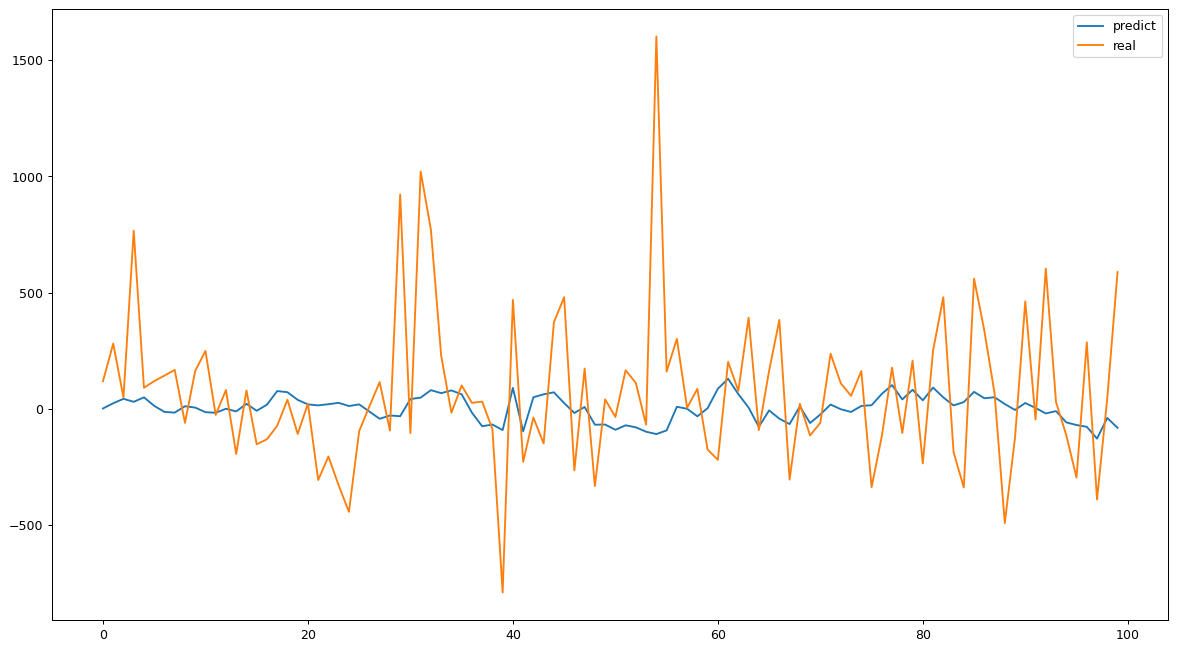

In [24]:
plt.figure(figsize=(16,9),dpi=90)
plt.plot(y_pred[:100], label="predict")
plt.plot(y_test[:100], label="real")
plt.legend()
plt.show()

In [25]:
tensorboard --logdir logs --load_fast true